<img src="https://drive.google.com/uc?id=1dFgNX9iQUfmBOdmUN2-H8rPxL3SLXmxn" width="400"/>


---


# **Recap of ML/DL basic concepts**


#### **Morning contents/agenda**

1. Supervised VS unsupervised learning

2. Parameters and hyperparameters of a network

  2.1 Activation functions 

  2.2 Losses

3. **Training is an optimisation problem**: gradient descent and backpropagation

4. Batch, mini-batch, and stochastic gradient descent

5. Bias and variance, and regularisers

#### **Learning outcomes**

1. Understand the difference between parameters of hyperparameters of a network

2. Understand how networks are trained using gradient descent and backpropagation

3. Understand how batch size works and the effect of regularisers in the training process


<br>

#### **Afternoon contents/agenda**

1. Half-moon classifier 

2. L2 regularisation on MNIST

#### **Learning outcomes**

1. Be able to build a simple classifier for simple datasets

2. Understand the effect of explicit regularisation during training

<br/>

---

<br/>

In [1]:
!pip install pycm livelossplot
%pylab inline

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 535 kB/s 
     |████████████████████████████████| 595 kB 37.9 MB/s 
     |████████████████████████████████| 1.6 MB 60.6 MB/s 
Populating the interactive namespace from numpy and matplotlib


In [2]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## 1. Half-moon classifier

#### Write a network with 2 hidden layers to perform a binary classification task on the provided dataset:

In [3]:
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score


def make_train_test(batch_size, batch_num, test_size, noise=0.01):
    """
    Makes a two-moon train-test dataset with fixed batch size, number and noise level
    """
    X_train, y_train = make_moons(n_samples=batch_size*batch_num, noise=noise)
    y_train = y_train.reshape(batch_num, batch_size, 1)
    X_train = X_train.reshape(batch_num, batch_size, 2)


    X_test, y_test = make_moons(noise=noise)
    y_test = y_test.reshape(test_size, 1)
    return X_train, y_train, X_test, y_test

#### Define a simple FFN with two hidden layers and sigmoid activations:

In [4]:
class SingleHiddenLayerNetwork(nn.Module):
    def __init__(self, I, H1, H2, O):
        super(SingleHiddenLayerNetwork, self).__init__()
        self.hidden_1 = nn.Linear(I, H1, bias=True)
        self.hidden_2 = nn.Linear(H1, H2, bias=True)
        self.output = nn.Linear(H2, O, bias=True)
        self.activation = nn.Sigmoid()
        
    def forward(self, X):
        z1 = self.hidden_1(X)
        a1 = self.activation(z1)
        z2 = self.hidden_2(a1)
        a2 = self.activation(z2)
        z3 = self.output(a2)
        a3 = self.activation(z3)
        return a3

#### Define your own loss, as well as train and evaluate functions:

In [5]:
# define the loss (criterion)
def bce_loss(y, a3):
    return -1/y.size(0)*(y*a3.log()+(1-y)*(1-a3).log()).sum(0)

# train function
def train(model, optimizer, data_loader):
    model.train()
    for X, y in data_loader:
        optimizer.zero_grad()
        a3 = model(X)
        loss = bce_loss(y, a3)
        loss.backward()
        optimizer.step()
    
    y_pred = np.where(a3[:, 0].detach().numpy()>0.5, 1, 0)
    accuracy = accuracy_score(y, y_pred)
    return loss, accuracy

# evaluate function
def evaluate(model, data_loader):
    model.eval()
    for X, y in data_loader:
        with torch.no_grad():
            a3 = model(X)
            loss = bce_loss(y, a3)
    y_pred = np.where(a3[:, 0].numpy()>0.5, 1, 0)
    accuracy = accuracy_score(y, y_pred)
    return loss, accuracy
    


Follow these steps:

- define hyperparameters (use full-batch training)
- create train and test TensorDatasets
- create train and test DataLoaders

In [6]:
# Define hyperparameters
set_seed(42)             # random seed
epochs = 1000            # number of loops through whole dataset
batch_size = 1000        # size of a single batch
batch_num = 1            # use full batch training
test_size = 100          # examples in test set
lr = 1.                  # learning rate
momentum = 0.9           # set momentum

#Define the size of the input, hidden, and output layers
I, H1, H2, O = 2, 3, 5, 1

#Use the function 'make_train_test' defined above to create two-moons + noise
X_train, y_train, X_test, y_test = make_train_test(batch_size, batch_num, test_size, noise=0.25)

#Define Train Set in Pytorch
X_train = torch.from_numpy(X_train).float()[0] #Convert to torch tensor, single batch
y_train = torch.from_numpy(y_train).float()[0] #Convert to torch tensor, single batch

train_dataset = TensorDataset(X_train, y_train)

#Define Test Set in Pytorch
X_test = torch.from_numpy(X_test).float() #Convert to torch tensor, already single batch
y_test = torch.from_numpy(y_test).float() #Convert to torch tensor, already single batch

test_dataset = TensorDataset(X_test, y_test)

#Use Pytorch's functionality to load data in batches. Here we use full-batch training again.
train_loader = DataLoader(train_dataset, batch_size=X_train.size(0), shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=X_test.size(0), shuffle=False)


        

### Instantiate your network and train it for 1000 epochs

In [7]:
network = SingleHiddenLayerNetwork(I, H1, H2, O)
optim = torch.optim.SGD(network.parameters(), lr=lr, momentum=0.9)
for i in range(1000):
    train_loss, train_accuracy = train(network, optim, train_loader)
    test_loss, test_accuracy = evaluate(network, test_loader)
    
    if i % 100 == 0:
        print("Training Loss in epoch "+str(i)+": %1.2f" % train_loss.item())
        print("Training accuracy in epoch "+str(i)+": %1.2f" % train_accuracy)
        print("Test Loss in epoch "+str(i)+": %1.2f" % test_loss.item())
        print("Test accuracy in epoch "+str(i)+": %1.2f" % test_accuracy, "\n")
                

Training Loss in epoch 0: 0.69
Training accuracy in epoch 0: 0.50
Test Loss in epoch 0: 0.69
Test accuracy in epoch 0: 0.50 

Training Loss in epoch 100: 0.31
Training accuracy in epoch 100: 0.85
Test Loss in epoch 100: 0.32
Test accuracy in epoch 100: 0.85 

Training Loss in epoch 200: 0.30
Training accuracy in epoch 200: 0.86
Test Loss in epoch 200: 0.32
Test accuracy in epoch 200: 0.84 

Training Loss in epoch 300: 0.14
Training accuracy in epoch 300: 0.94
Test Loss in epoch 300: 0.16
Test accuracy in epoch 300: 0.94 

Training Loss in epoch 400: 0.13
Training accuracy in epoch 400: 0.94
Test Loss in epoch 400: 0.16
Test accuracy in epoch 400: 0.94 

Training Loss in epoch 500: 0.13
Training accuracy in epoch 500: 0.95
Test Loss in epoch 500: 0.16
Test accuracy in epoch 500: 0.94 

Training Loss in epoch 600: 0.13
Training accuracy in epoch 600: 0.94
Test Loss in epoch 600: 0.16
Test accuracy in epoch 600: 0.95 

Training Loss in epoch 700: 0.13
Training accuracy in epoch 700: 0.94


Use the code snippets provided to plot the training and set classified points of the half-moon.

Test set accuracy:  0.95


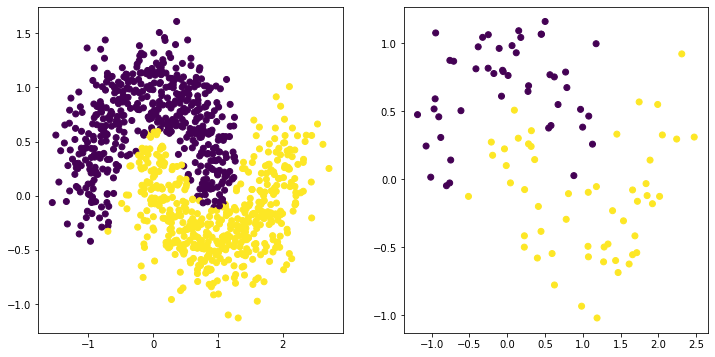

In [8]:
network.eval()
with torch.no_grad():
    a_train = network(X_train)
    a_test = network(X_test)
print("Test set accuracy: ", accuracy_score(y_test, np.where(a_test[:, 0].numpy()>0.5, 1, 0)))
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(X_train[:, 0], X_train[:, 1], c=np.where(a_train[:, 0].numpy()>0.5, 1, 0))
ax[1].scatter(X_test[:, 0], X_test[:, 1], c=np.where(a_test[:, 0].numpy()>0.5, 1, 0))



<br>

---

<br>

## 2. L2 regularisation on MNIST

Add L2 regularisation to this morning training with MNIST

\[**HINT**: there is a way to do it that only involves changing one line of code, check the arguments of SGD [here](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)\]

You can copy paste the code blocks you need from this morning session.

In [ ]:
# create a simple network
class simpleFFN(nn.Module):
  def __init__(self):
    super(simpleFFN, self).__init__()
    self.hidden_1 = nn.Linear(784, 200, bias=True)
    self.hidden_2 = nn.Linear(200, 50, bias=True)
    self.hidden_3 = nn.Linear(50,200, bias=True)
    self.output = nn.Linear(200, 10, bias=False)
    self.activation = nn.Mish()  ## Debbie loves this one ;-)
    
  def forward(self, X):
    z1 = self.hidden_1(X)
    a1 = self.activation(z1)
    z2 = self.hidden_2(a1)
    a2 = self.activation(z2)
    z3 = self.hidden_3(a2)
    a3 = self.activation(z3)
    z4 = self.output(a3)
    a4 = self.activation(z4)
    return a4

# test that it runs  
x = torch.randn((1, 1, 784))
model = simpleFFN()
y = model(x)
print(y)
print(model)

tensor([[[ 0.0196, -0.0023,  0.0156,  0.0244,  0.0246,  0.0348, -0.0069,
           0.0239, -0.0263, -0.0345]]], grad_fn=<MishBackward0>)
simpleFFN(
  (hidden_1): Linear(in_features=784, out_features=200, bias=True)
  (hidden_2): Linear(in_features=200, out_features=50, bias=True)
  (hidden_3): Linear(in_features=50, out_features=200, bias=True)
  (output): Linear(in_features=200, out_features=10, bias=False)
  (activation): Mish()
)


In [ ]:
# download MNIST
mnist_train = MNIST("./", download=True, train=True)
mnist_test = MNIST("./", download=True, train=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
# split the data
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(mnist_train.train_data, mnist_train.train_labels) 
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

# define an standardisation function
def apply_standardization(X): 
  X /= 255.
  X -= 0.1307
  X /= 0.3081
  return X

# standardise the data
X_train, y_train = apply_standardization(mnist_train.train_data[indices[0]].float()), mnist_train.train_labels[indices[0]]
X_val, y_val = apply_standardization(mnist_train.train_data[indices[1]].float()), mnist_train.train_labels[indices[1]]
X_test, y_test =  apply_standardization(mnist_test.test_data.float()), mnist_test.test_labels

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  wa

In [ ]:
# create the TensorDatasets containing mnist_train, mnist_validate, and mnist_test
mnist_train = TensorDataset(X_train, y_train.long())
mnist_validate = TensorDataset(X_val, y_val.long())
mnist_test = TensorDataset(X_test, y_test.long())

In [ ]:
# implement training and validation functions

def train(model, optimizer, criterion, data_loader):
    model.train()                         # the model is in the training mode so the parameters(weights)to be optimised will be updated
    train_loss, train_accuracy = 0, 0     # initialise loss and accuracy to 0 for training
    for X, y in data_loader:              # iterate over the mini-batches defined in the data loader
        X, y = X.to(device), y.to(device) # send data to the device (GPU in our case)
        optimizer.zero_grad()             # resetting optimiser info
        a2 = model(X.view(-1, 28*28))     # forward pass
        loss = criterion(a2, y)           # compute loss
        loss.backward()                   # backpropagation to calculate the gradients
        train_loss += loss*X.size(0)      # # add it up for different mini-batches and undo loss normalisation
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]  # get predictions
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0) # compute accuracy
        optimizer.step()                  # perform a step of gradient descent
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)  # here we can average over the whole dataset


def validate(model, criterion, data_loader):      # does not need optimiser
    model.eval()                                  # model is set to evaluation mode so no dropout or any other funny stuff here
    validation_loss, validation_accuracy = 0., 0. # initialise loss and accuracy to 0 for training
    for X, y in data_loader:                      # iterate over the mini-batches defined in the data loader
        with torch.no_grad():                     # deactivates autograd engine
            X, y = X.to(device), y.to(device)     # send data to the device (GPU in our case)
            a2 = model(X.view(-1, 28*28))         # forward pass
            loss = criterion(a2, y)               # evaluate loss
            validation_loss += loss*X.size(0)     # add it up for different mini-batches and undo loss normalisation
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]  # get predictions
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0) # compute accuracy
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)  # here we can average over the whole dataset

In [ ]:
# set hyperparameters

seed = 42
lr = 1e-2
momentum = 0.9
batch_size = 64  # here batch_size really refers to what we have described as mini-batch
test_batch_size = 1000
n_epochs = 30
weight_decay = 0.01   ### this is the magic line!

set_seed(seed)
model = simpleFFN().to(device)                                              # instantiate model and send it to the GPU
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)   # instantiate the optimizer
criterion = nn.CrossEntropyLoss() 

We have defined a new parameter in the optimiser called `weight_decay`. This parameter is equivalen to adding L2 regularisation. Check the documentation of the `SGD` optimiser in `PyTorch` [here](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)

In [ ]:
# create DataLoaders

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0) ## num_workers=0 means that the main process will retrieve the data.
validation_loader = DataLoader(mnist_validate, batch_size=test_batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False, num_workers=0)

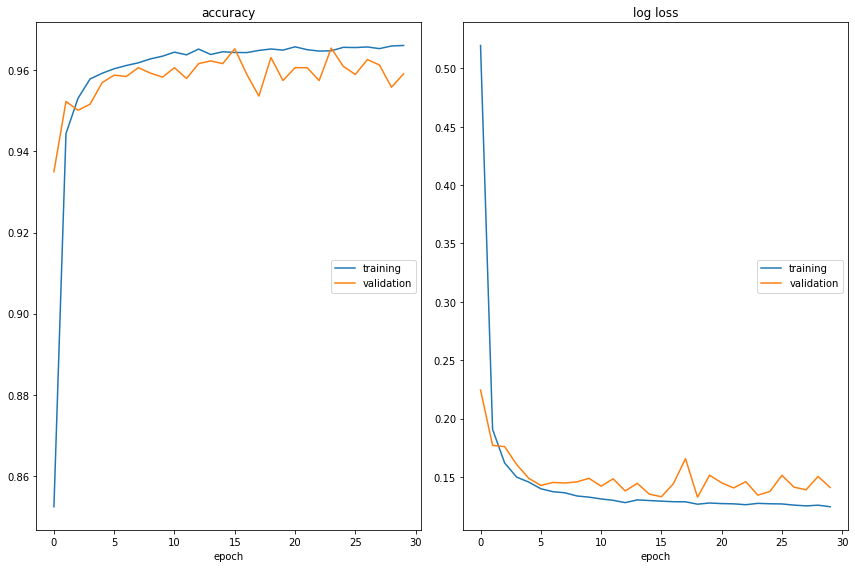

accuracy
	training         	 (min:    0.852, max:    0.966, cur:    0.966)
	validation       	 (min:    0.935, max:    0.966, cur:    0.959)
log loss
	training         	 (min:    0.124, max:    0.520, cur:    0.124)
	validation       	 (min:    0.133, max:    0.224, cur:    0.141)
0.14087200164794922


In [ ]:
# train for the number of epochs specified

set_seed(seed)
liveloss = PlotLosses()    # plots evolution of loss and accuracy
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    
    validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()
    
    liveloss.update(logs)
    liveloss.draw()
    print(validation_loss.item())

We can observe that now we have a lower generalisation error (loss and accuracy of training and validation are more similar).

We have failed to keep the accuracy as high as it was previously though, so there is a balance to be found here. This is a simple example to illustrate the concept, in real applications we would be better off without regularisation.

<br>

Results from this morning for reference:

<img src="https://drive.google.com/uc?id=1n-v2kP-RPB24PEJWhlETNC5DRHuqbBSz" width="600"/>
